In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

# using Plots
using CairoMakie
using Random
using Printf
using DataFrames
using JLD
using StatsPlots
using LinearAlgebra
using NearestNeighbors
using DataInterpolations
using Clustering
using GraphMakie
using Graphs
using ClusterValidityIndices
using MultivariateStats


example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))

Dict{String, Any} with 6 entries:
  "bistable"     => NaN
  "feed_forward" => [0.0 0.0 0.0 0.19495; 0.173532 0.0 0.0 0.0; 3.02262 -5.5322…
  "classical"    => [0.0 0.0 0.0 0.114353; -0.560775 0.359711 0.0 0.0; -0.07258…
  "frozen_osc"   => NaN
  "mutual_inh"   => [0.0 0.0 0.0 0.2454; 0.455819 0.0 -2.23319 0.0; 0.446651 -2…
  "overlap_dom"  => [0.0 0.0 -0.00379469 0.228214; 0.653415 0.0 0.0 0.0; -0.424…

In [3]:


# # run_data = load(datadir("sims/repeated_evolution_different_topologies/a1.jld2"))["raw_data"];

run_data = load(datadir("sims/repeated_evolution_different_topologies/max_gen=20000_mutation_method=all_viable_n_traj=20000_noise_cv=1.0_noise_method=additive_start_network_name=c100_w40_topology=overlap_dom_β=Inf.jld2"))["raw_data"];

In [4]:
function refresh_type(v)
    [i for i in v]
end

function attach_column_to_tuples(column::Vector{Float64},tuples::Vector{Tuple{Float64,Float64}})
    return hcat(column,hcat(first.(tuples), last.(tuples)))
end

function tuples_to_matrix(tuples::Vector{Tuple{Float64,Float64}})
    return hcat(first.(tuples), last.(tuples))
end


tuples_to_matrix (generic function with 1 method)

In [5]:
mutable struct PhenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    pheno_traj :: Vector{Vector{Tuple{Float64, Float64}}}
    traj_m ::Vector{Matrix{Float64}}
    initial_fitness :: Float64
    initial_phenotype :: Tuple{Float64,Float64}

    full_pheno_traj :: Union{Vector{Vector{Tuple{Float64, Float64}}}, Nothing}
    cluster_assignments :: Union{Vector{Int64}, Nothing}
    fpt_data :: Union{Matrix{Float64},Nothing}
    distance_mat ::  Union{Matrix{Float64},Nothing}

    max_clusters :: Union{Int64, Nothing}
    optimal_n_cluster :: Union{Int64, Nothing}
    criterion_values :: Union{Vector{Float64},Nothing}
    
    debug ::Any
end

mutable struct GenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    traj :: Vector{Vector{Matrix{Float64}}}

    geno_traj :: Vector{Matrix{Float64}}

    initial_fitness :: Float64
    initial_genotype :: Vector{Float64}

    full_geno_traj :: Union{Vector{Matrix{Float64}}, Nothing}
    cluster_assignments :: Union{Vector{Int64}, Nothing}
    fgt_data :: Union{Matrix{Float64},Nothing}
    distance_mat ::  Union{Matrix{Float64},Nothing}

    max_clusters :: Union{Int64, Nothing}
    optimal_n_cluster :: Union{Int64, Nothing}
    criterion_values :: Union{Vector{Float64},Nothing}

    debug ::Any
end

function PhenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(map(x->x[2],et.fitness_trajectory)),evo_traces)
    pheno_traj = map(et->refresh_type(reduce(vcat,et.traversed_phenotypes)),evo_traces)

    traj_m = map(x->tuples_to_matrix(x) |> transpose |> collect,pheno_traj);

    initial_fitness = fitness_traj[1][1]
    initial_phenotype = pheno_traj[1][1]

    if initial_fitness < 0
        PhenoTrajectories(fitness_traj,pheno_traj,traj_m,initial_fitness, initial_phenotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)
    else
        fitness_traj = map(x-> -1 .* x,fitness_traj)
        PhenoTrajectories(fitness_traj,pheno_traj,traj_m,-initial_fitness, initial_phenotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)
    end

end

function GenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(map(x->x[2],et.fitness_trajectory)),evo_traces)
    geno_traj = map(et->reduce(hcat,map(x->vec(x),et.traversed_topologies)),evo_traces);

    traj = map(et->unique(et.traversed_topologies),evo_traces);

    initial_fitness = fitness_traj[1][1]
    initial_genotype = vec(evo_traces[1].traversed_topologies[1])

    if initial_fitness < 0
        GenoTrajectories(fitness_traj,traj,geno_traj,initial_fitness, initial_genotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)
    else
        fitness_traj = map(x-> -1 .* x,fitness_traj)
        GenoTrajectories(fitness_traj,traj,geno_traj,-initial_fitness, initial_genotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)
    end
end



# mutable struct GenoTrajectories

#     fitness_traj :: Vector{Vector{Float64}}
#     traj :: Vector{Vector{Matrix{Float64}}}

#     geno_traj :: Vector{Matrix{Float64}}

#     initial_fitness :: Float64
#     initial_genotype :: Vector{Float64}

#     full_geno_traj :: Union{Vector{Matrix{Float64}}, Nothing}
#     cluster_assignments :: Union{Vector{Int64}, Nothing}
#     fgt_data :: Union{Matrix{Float64},Nothing}
#     distance_mat ::  Union{Matrix{Float64},Nothing}

#     max_clusters :: Union{Int64, Nothing}
#     optimal_n_cluster :: Union{Int64, Nothing}
#     criterion_values :: Union{Vector{Float64},Nothing}

#     debug ::Any
# end


# function GenoTrajectories(evo_traces::Vector{EvoTrace})

#     fitness_traj = map(et->refresh_type(map(x->x[1],et.fitness_trajectory)),evo_traces)
#     geno_traj = map(et->reduce(hcat,map(x->vec(x),et.traversed_topologies)),evo_traces);

#     traj = map(et->unique(et.traversed_topologies),evo_traces);

#     initial_fitness = fitness_traj[1][1]
#     initial_genotype = vec(evo_traces[1].traversed_topologies[1])


#     GenoTrajectories(fitness_traj,traj,geno_traj,initial_fitness, initial_genotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)

# end

GenoTrajectories

In [6]:
evo_traces = map(x->x[2],run_data);

gt = GenoTrajectories(evo_traces);

In [7]:
diff = gt.geno_traj[1][:,2:end] .- gt.geno_traj[1][:,1:end-1] 

diff_rel = diff ./ gt.geno_traj[1][:,1:end-1] 

# mapslices(col->findall(x->x!=0,col),diff,dims =1)



12×24 Matrix{Float64}:
 NaN        NaN        NaN          …  NaN        NaN         NaN
   0.0        0.0        0.0             0.0        0.0         0.10985
  -0.0       -0.0       -0.0            -0.0       -0.0        -0.0
 NaN        NaN        NaN              -0.0        0.120799   -0.0
 NaN        NaN        NaN               1.16198   -0.0        -0.0
   0.0        0.0        0.0        …    0.0        0.0         0.0
   1.47881    0.19889    0.0399326      -0.0       -0.0        -0.0
 NaN        NaN        NaN             NaN        NaN         NaN
 NaN        NaN        NaN              -0.0       -0.0        -0.0
   0.0        0.0        0.0             0.0        0.0         0.0
 NaN        NaN        NaN          …  NaN        NaN         NaN
 NaN        NaN        NaN             NaN        NaN         NaN

In [8]:
diff

12×24 Matrix{Float64}:
  0.0          0.0         …   0.0         0.0         0.0
  0.0          0.0             0.0         0.0         0.0717776
  0.0          0.0             0.0         0.0         0.0
  0.0          0.0             0.0        -0.00423496  0.0
  0.0          0.0            -0.0276997   0.0         0.0
  0.0          0.0         …   0.0         0.0         0.0
 -0.00561164  -0.00187082      0.0         0.0         0.0
  0.0          0.0             0.0         0.0         0.0
  0.0          0.0             0.0         0.0         0.0
  0.0          0.0             0.0         0.0         0.0
  0.0          0.0         …   0.0         0.0         0.0
  0.0          0.0             0.0         0.0         0.0

In [9]:
-0.00561164 / -0.00379469 

1.4788138161483548

In [10]:
gt.fitness_traj[1][end] - gt.fitness_traj[1][1]

3540.0

In [11]:
function create_pairs(gm,gf)
    diff_gm = gm[:,2:end] .- gm[:,1:end-1] 
    diff_gf = (gf[2:end] .- gf[1:end-1]) ./ (gf[end] - gf[1])

    wi = mapslices(col->findall(x->x!=0,col),diff_gm,dims =1)

    diff_gm_rel =  diff_gm ./ gm[:,1:end-1] 

    result = []

    for (n,i) in enumerate(wi)

        push!(result,(i,diff_gf[n],diff_gm[i,n],diff_gm_rel[i,n]))
    end

    return result

end



create_pairs (generic function with 1 method)

In [12]:
unique(gt.fitness_traj[2])

12-element Vector{Float64}:
 -3540.5
 -3390.5
 -1062.5
  -232.0
   -96.5
   -90.0
   -26.5
   -22.5
   -20.0
   -13.0
    -2.5
    -2.0

In [13]:
gt.geno_traj[2]

12×12 Matrix{Float64}:
  0.0          0.0          0.0         …   0.0          0.0
  0.653415     0.653415     0.653415        0.555484     0.555484
 -0.424533    -0.424533    -0.424533       -1.13192     -1.25732
  0.0          0.0         -0.056019       -0.051305    -0.051305
  0.0          0.0          0.0             0.0          0.0
  0.150029     0.339058     0.339058    …   0.294778     0.294778
 -0.00379469  -0.00379469  -0.00379469     -0.00323737  -0.00323737
  0.0          0.0          0.0             0.0          0.0
  0.0          0.0          0.0             0.0          0.0
  0.228214     0.228214     0.228214        0.228214     0.228214
  0.0          0.0          0.0         …   0.0          0.0
  0.0          0.0          0.0             0.0          0.0

In [14]:
fitness_weight_pairs = map(t->create_pairs(t[1],unique(t[2])),zip(gt.geno_traj,gt.fitness_traj));

In [15]:
all_fwp = reduce(vcat,fitness_weight_pairs);

In [16]:
all_fwp

287165-element Vector{Any}:
 (7, 0.09774011299435029, -0.005611637552271294, 1.478814197118862)
 (7, 0.031638418079096044, -0.0018708240488174207, 0.19889000909812965)
 (7, 0.015112994350282486, -0.0004503258388577937, 0.03993259644998416)
 (6, 0.056638418079096045, 0.09051968248129302, 0.6033465161459991)
 (3, 0.04505649717514124, 0.09683509899967369, -0.22809795519763887)
 (3, 0.012146892655367232, 0.029091657594124354, -0.08877585569120151)
 (6, 0.015819209039548022, 0.027591220609552936, 0.114701027586144)
 (6, 0.033757062146892655, 0.059606653457053405, 0.22229655538305942)
 (4, 0.15974576271186441, -0.01974061665284962, -Inf)
 (7, 0.059463276836158194, -0.005131551562032372, 0.43756662422305215)
 ⋮
 (6, 0.003532570298148933, -0.06192280817886803, -0.28466181187158907)
 (6, 0.00211954217888936, 0.013570307417201083, 0.08720810345898658)
 (1, 0.010739013706372758, -0.0072097450754717626, 2.0210718250055932)
 (1, 0.0062173237247421225, -0.007516125735460365, 0.6974206861412822)
 (3,

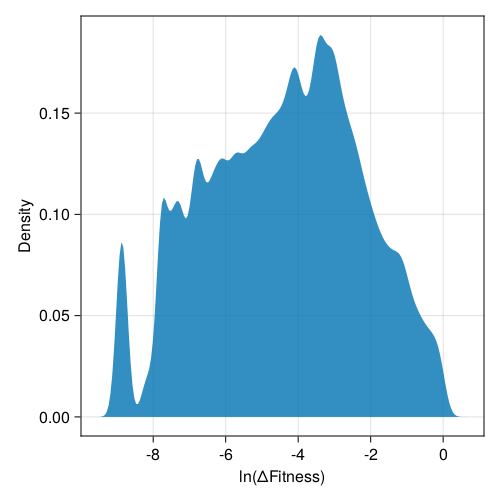

In [17]:
fig = CairoMakie.Figure(resolution = (500,500))
ax = Axis(fig[1,1]; xlabel="ln(ΔFitness)", ylabel="Density")

CairoMakie.density!(ax, log.(map(x->x[2],all_fwp)),nbins = 100)

fig

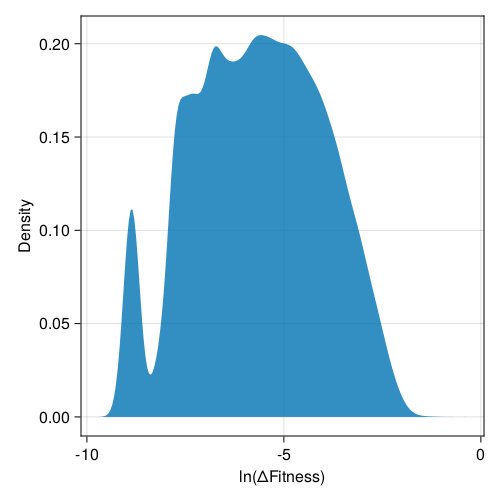

In [18]:
fig = CairoMakie.Figure(resolution = (500,500))
ax = Axis(fig[1,1]; xlabel="ln(ΔFitness)", ylabel="Density")

CairoMakie.density!(ax, log.(map(x->x[2],filter(x->x[1] == 9,all_fwp))),nbins = 100)

fig

In [19]:
fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

for wi in 1:10

    ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel="ln(ΔFitness)", ylabel="Density", title = weight_names[wi])

    # CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 3.5,color = map(x->x == wi ? color_scheme[wi] : :grey,traj_fm_class_v[choice_full_v]))

    CairoMakie.density!(ax1, log.(map(x->x[2],filter(x->x[1] == wi,all_fwp))),color = color_scheme[wi],nbins = 50)

    push!(ax_list,ax)

end

linkxaxes!(ax_list...)

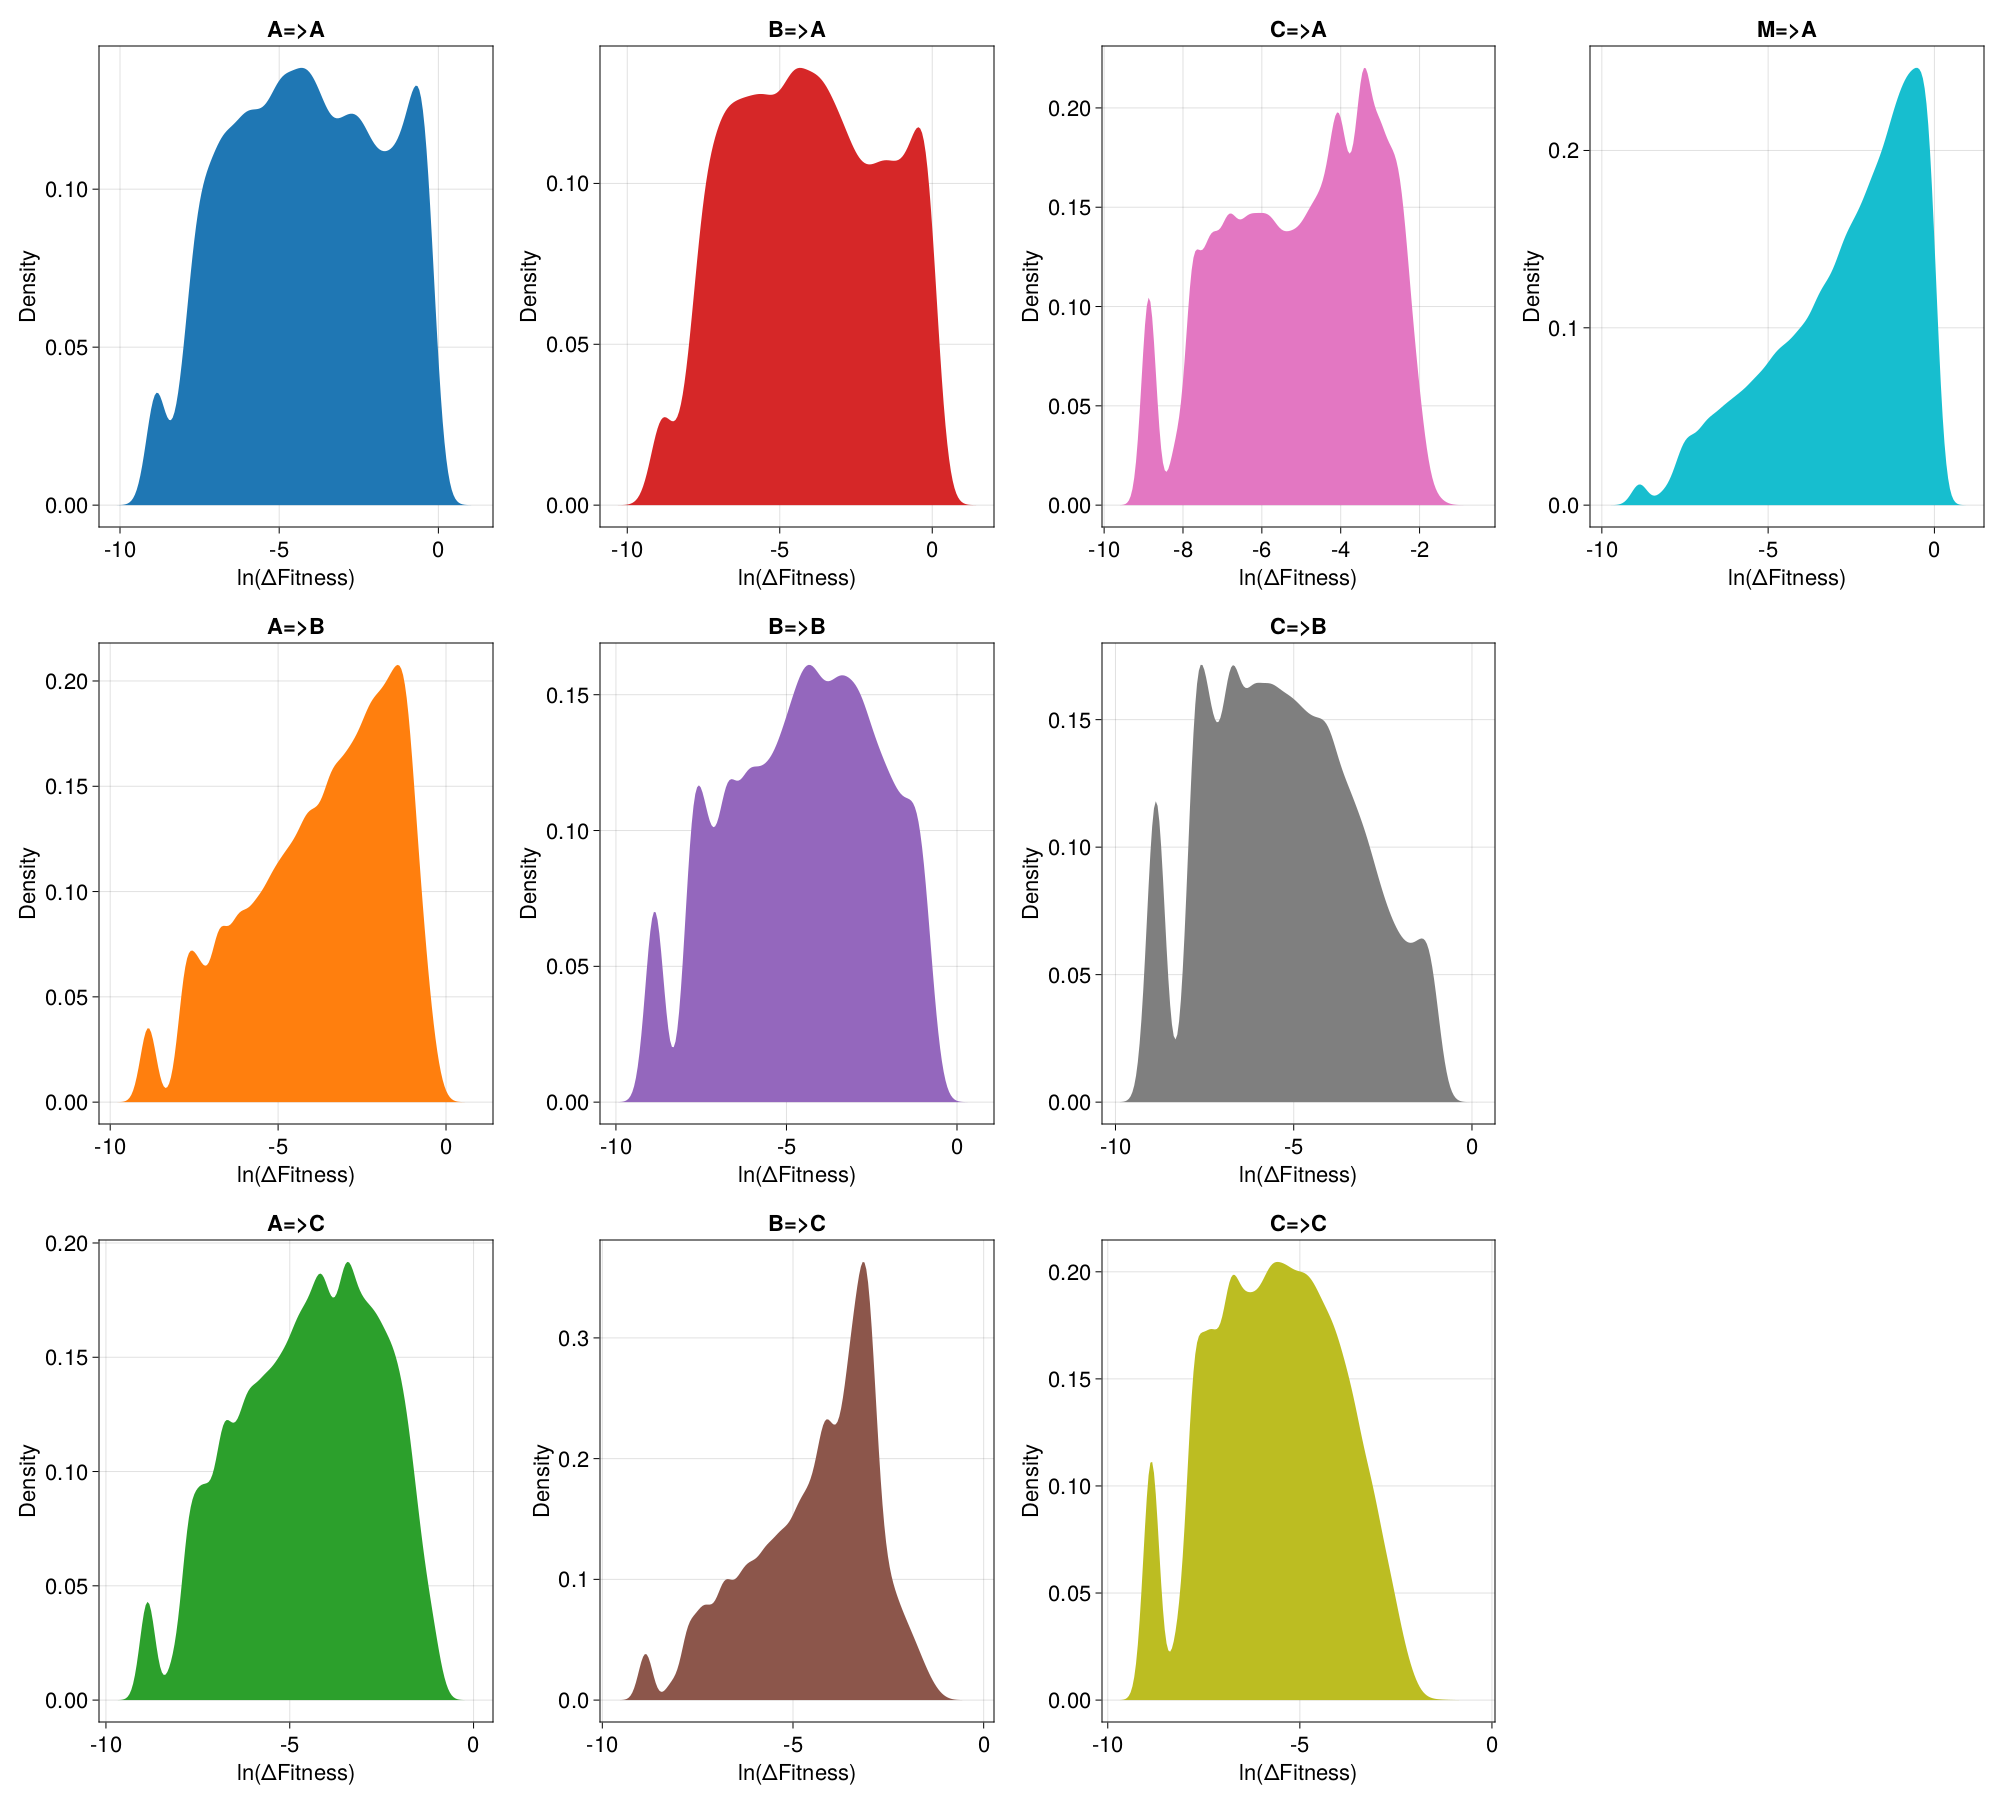

In [20]:
fig

In [21]:
# CairoMakie.save("tiny_weight_fitness_no_log.png",fig)

In [22]:
thresh = 0.2

fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

all_fwp_nn = filter(x->abs(x[4]) != Inf,all_fwp)

for wi in 1:10

    ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel="ln(Relative ΔFitness)", ylabel="Density", title = weight_names[wi] *  ", |Relative Δ(" * weight_names[wi] * ")| < " * string(thresh)) 

    # CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 3.5,color = map(x->x == wi ? color_scheme[wi] : :grey,traj_fm_class_v[choice_full_v]))

    CairoMakie.density!(ax1, log.(map(x->x[2],filter(x->x[1] == wi,all_fwp_nn))),color = color_scheme[wi],nbins = 100)
    CairoMakie.density!(ax1, log.(map(x->x[2],filter(x->x[1] == wi && abs(x[4]) < thresh,all_fwp_nn))),color = (:red,0.25),nbins = 100)

    push!(ax_list,ax)

end

linkxaxes!(ax_list...)

In [23]:
# CairoMakie.save("weight_shift.png",fig)

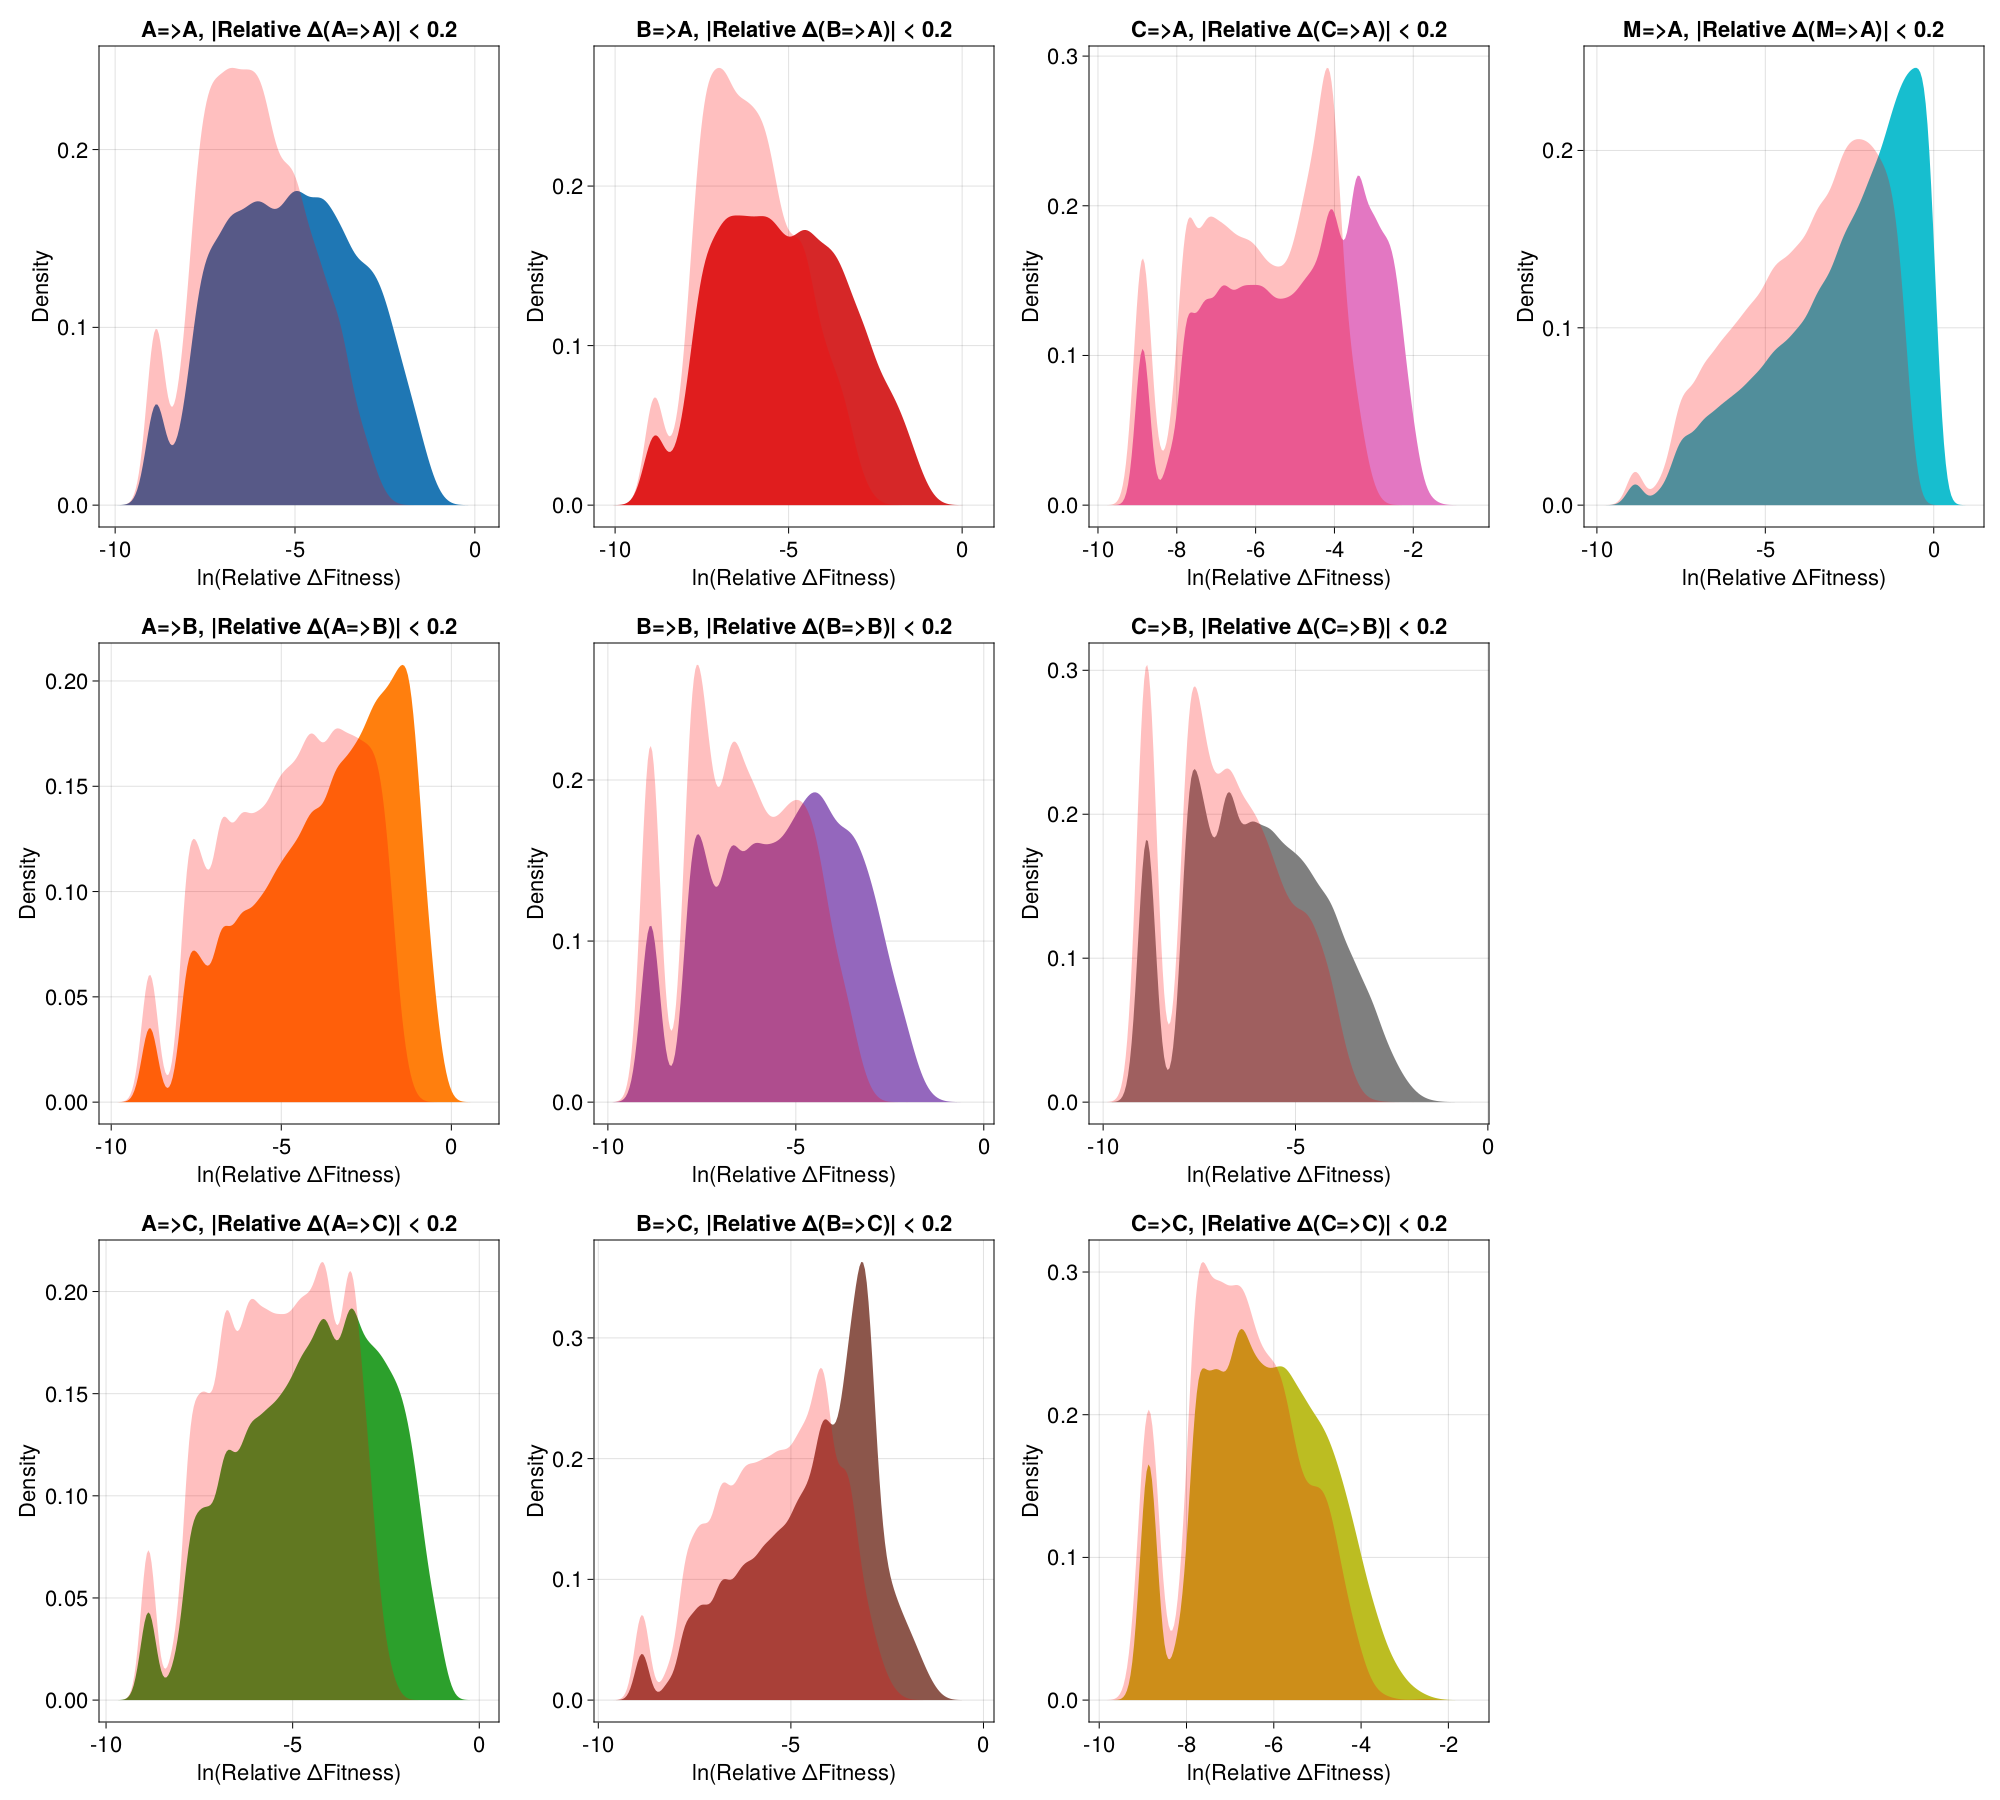

In [24]:
fig

In [25]:
# CairoMakie.save("weight_shift_small.png",fig)

In [26]:
function longest_contiguous_subsequence(a, b)
    m = zeros(Int, length(a) + 1, length(b) + 1)
    longest, x_longest, y_longest = 0, 0, 0

    for x in 2:(length(a) + 1)
        for y in 2:(length(b) + 1)

            if a[x - 1] == b[y - 1]
                m[x, y] = m[x - 1, y - 1] + 1

                if m[x, y] > longest
                    longest = m[x, y]
                    x_longest = x
                    y_longest = y
                end
            else
                m[x, y] = 0
            end

        end
    end

    a_range = (x_longest - longest):(x_longest - 1)
    b_range = (y_longest - longest):(y_longest - 1)
    a[a_range], a_range, b_range
end

longest_contiguous_subsequence (generic function with 1 method)

In [27]:
a = "hippotamous"
b = "rhinocerous"

longest_contiguous_subsequence(a, b)

("ous", 9:11, 9:11)

In [28]:
function create_mutation_string(gm)
    diff_gm = gm[:,2:end] .- gm[:,1:end-1] 

    wi = mapslices(col->findall(x->x!=0,col),diff_gm,dims =1)

    return join(string.(wi))

end


create_mutation_string (generic function with 1 method)

In [29]:
create_mutation_string(gt.geno_traj[1])

"777633664769447436953542"

In [30]:
mstring = map(x->create_mutation_string(x),gt.geno_traj);

In [31]:
longest_contiguous_subsequence(mstring[1], mstring[2])

("436", 16:18, 2:4)

In [32]:
longest_contiguous_subsequence(mstring[10], mstring[20])

("27", 1:2, 1:2)

In [33]:
longest_contiguous_subsequence(mstring[100], mstring[200])

("63", 2:3, 8:9)

In [34]:
function pairwise_substring(mstrings)

    n = length(mstrings)

    results = []

    for i in 1:n
        for j in 1:n
            if i > j
                a,b,c = longest_contiguous_subsequence(mstrings[i], mstrings[j])
                push!(results,a)
            end
        end
    end

    return results
end

pairwise_substring (generic function with 1 method)

In [35]:
pwmstring = pairwise_substring(mstring[1:5000])

12497500-element Vector{Any}:
 "436"
 "53"
 "62"
 "77"
 "77"
 "55"
 "77"
 "73"
 "101"
 "39"
 ⋮
 "610"
 "77"
 "6777"
 "106"
 "677"
 "8210"
 "10"
 "67"
 "83"

In [37]:
countmap(pwmstring)

Dict{Any, Int64} with 21955 entries:
  "5734"     => 1
  "26767"    => 6
  "10467"    => 1
  "108777"   => 2
  "599"      => 101
  "1077831"  => 1
  "322102"   => 2
  "228"      => 811
  "1011171"  => 1
  "2106107"  => 3
  "8975"     => 2
  "661022"   => 4
  "371036"   => 3
  "3991"     => 6
  "2562"     => 2
  "91022"    => 19
  "15711"    => 1
  "10107736" => 1
  "9682"     => 1
  ⋮          => ⋮

In [45]:
pwm_count = countmap(map(x->length(x),pwmstring))

Dict{Int64, Int64} with 14 entries:
  5  => 257314
  12 => 1
  8  => 1567
  1  => 684706
  0  => 10034
  6  => 47683
  11 => 12
  9  => 287
  3  => 4539024
  7  => 8637
  4  => 1253731
  13 => 1
  2  => 5694468
  10 => 35

In [44]:
length(pwmstring)

12497500

In [53]:
sub_dens = [(n,log(c/length(pwmstring))) for (n,c) in pwm_count]

14-element Vector{Tuple{Int64, Float64}}:
 (5, -3.8829867742871023)
 (12, -16.341039182269864)
 (8, -8.984120939913842)
 (1, -2.9042943542372215)
 (0, -7.127304577225664)
 (6, -5.56870896304689)
 (11, -13.856132532481862)
 (9, -10.681556966510241)
 (3, -1.012816613336977)
 (7, -7.2772286029895765)
 (4, -2.299404718662802)
 (13, -16.341039182269864)
 (2, -0.7860334470464799)
 (10, -12.785691120780449)

In [62]:
sub_dens_null = [(n,log(0.1^n)) for (n,c) in pwm_count]

14-element Vector{Tuple{Int64, Float64}}:
 (5, -11.512925464970229)
 (12, -27.631021115928547)
 (8, -18.420680743952364)
 (1, -2.3025850929940455)
 (0, 0.0)
 (6, -13.815510557964274)
 (11, -25.3284360229345)
 (9, -20.72326583694641)
 (3, -6.907755278982137)
 (7, -16.11809565095832)
 (4, -9.210340371976182)
 (13, -29.933606208922594)
 (2, -4.605170185988091)
 (10, -23.025850929940457)

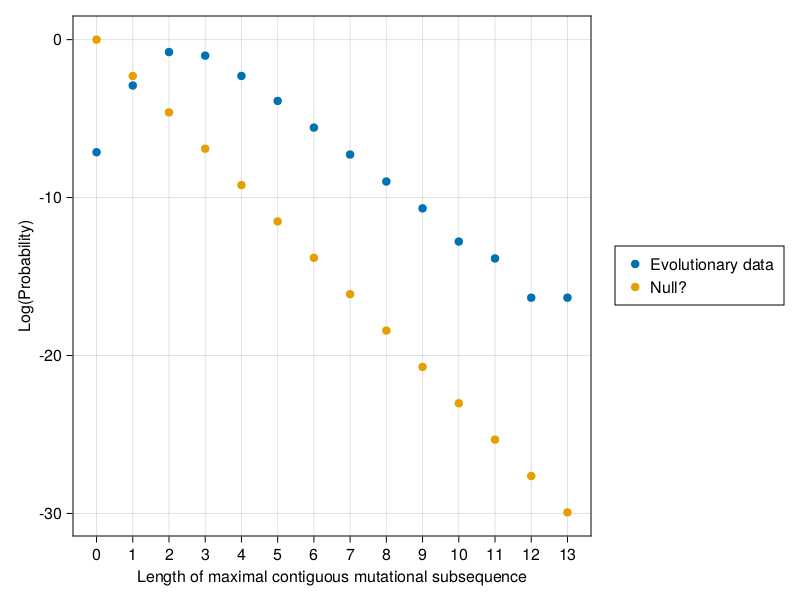

In [67]:
fig = CairoMakie.Figure()
ax = Axis(fig[1,1],xlabel = "Length of maximal contiguous mutational subsequence",ylabel = "Log(Probability)", xticks = (0:13,string.(0:13)))
CairoMakie.scatter!(ax,sub_dens,label = "Evolutionary data")
CairoMakie.scatter!(ax,sub_dens_null, label = "Null?")

leg = Legend(fig[1,2],ax)

fig

In [52]:
0.1^4

0.00010000000000000002

In [ ]:
# correlate with end network similarity